In [1]:
import numpy as np
from lib.dvr2d import *
from lib.utils import *
from lib.pot_gen import *
import matplotlib.pyplot as plt

from qiskit import Aer
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP, BOBYQA, NELDER_MEAD, SNOBFIT
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.quantum_info.operators import Operator
from qiskit.opflow import PrimitiveOp
%matplotlib inline

plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["font.size"] = 14
plt.rcParams["figure.dpi"] = 300

%load_ext autoreload

In [2]:
pot = get_pot('arhcl.txt', True)

In [3]:
%autoreload
N_R = 200
N_theta = 20
l = 1
K_max = 0
r_min = 3
r_max = 12

Rs_DVR, Xs_K = get_DVR_Rtheta(N_R, N_theta, 0, l=l, r_min=r_min, r_max=r_max)
Rs_angs = Rs_DVR * arhcl_params['S'] * au_to_angs
N_R_lim = Rs_angs.shape[0]
print(N_R_lim)

h_dvr = get_ham_DVR(pot2d, N_R, N_theta, 0, 0, l=l, r_min=r_min, r_max=r_max, trunc=0) * hartree
eigvals, eigvecs = np.linalg.eigh(h_dvr)
print(eigvals[:5])

TypeError: get_DVR_Rtheta() got an unexpected keyword argument 'l'

In [9]:
print(eigvals[:3] - np.array([-115.10766571457862, -90.02822259734776, -83.06851196396681]))
print(eigvals[:3] - np.array([-115.17015261836136, -90.80817274232922, -82.74653429786801]))

[-0.16021886 -1.61643714  0.23976883]
[-0.09773195 -0.836487   -0.08220883]


In [4]:
%autoreload
dvr_options = {
    'type': 'jacobi',
    'N_R': 20, 
    'N_theta': 4,
    'l': 1,
    'K_max': 0,
    'r_min': 3,
    'r_max': 6, 
    'trunc': 0,
    'J': 0
}

# dvr_options = {
#     'type': 'jacobi',
#     'J': 0,
#     'N_R': 50, 
#     'N_theta': 4,
#     'l': 1,
#     'K_max': 0,
#     'r_min': 3,
#     'r_max': 7, 
#     'trunc': 0
# }

Rs_DVR, Xs_K = get_DVR_Rtheta(dvr_options, arhcl_params)
Rs_angs = Rs_DVR * arhcl_params['S'] * au_to_angs
print(Rs_angs)
print(Rs_angs.shape)
N_R_lim = Rs_angs.shape[0]

h_dvr = get_ham_DVR(pot, dvr_options, arhcl_params) * hartree
print(h_dvr.shape)
eigvals, eigvecs = np.linalg.eigh(h_dvr)
print(eigvals[:5])

[3.11703214 3.27457708 3.48976791 3.76416941 4.09940502 4.49746023
 4.96079448 5.49244677]
(8,)
(32, 32)
[-114.12841556  -91.4928004   -80.62636053  -64.14979156  -54.57411506]


<BarContainer object of 32 artists>

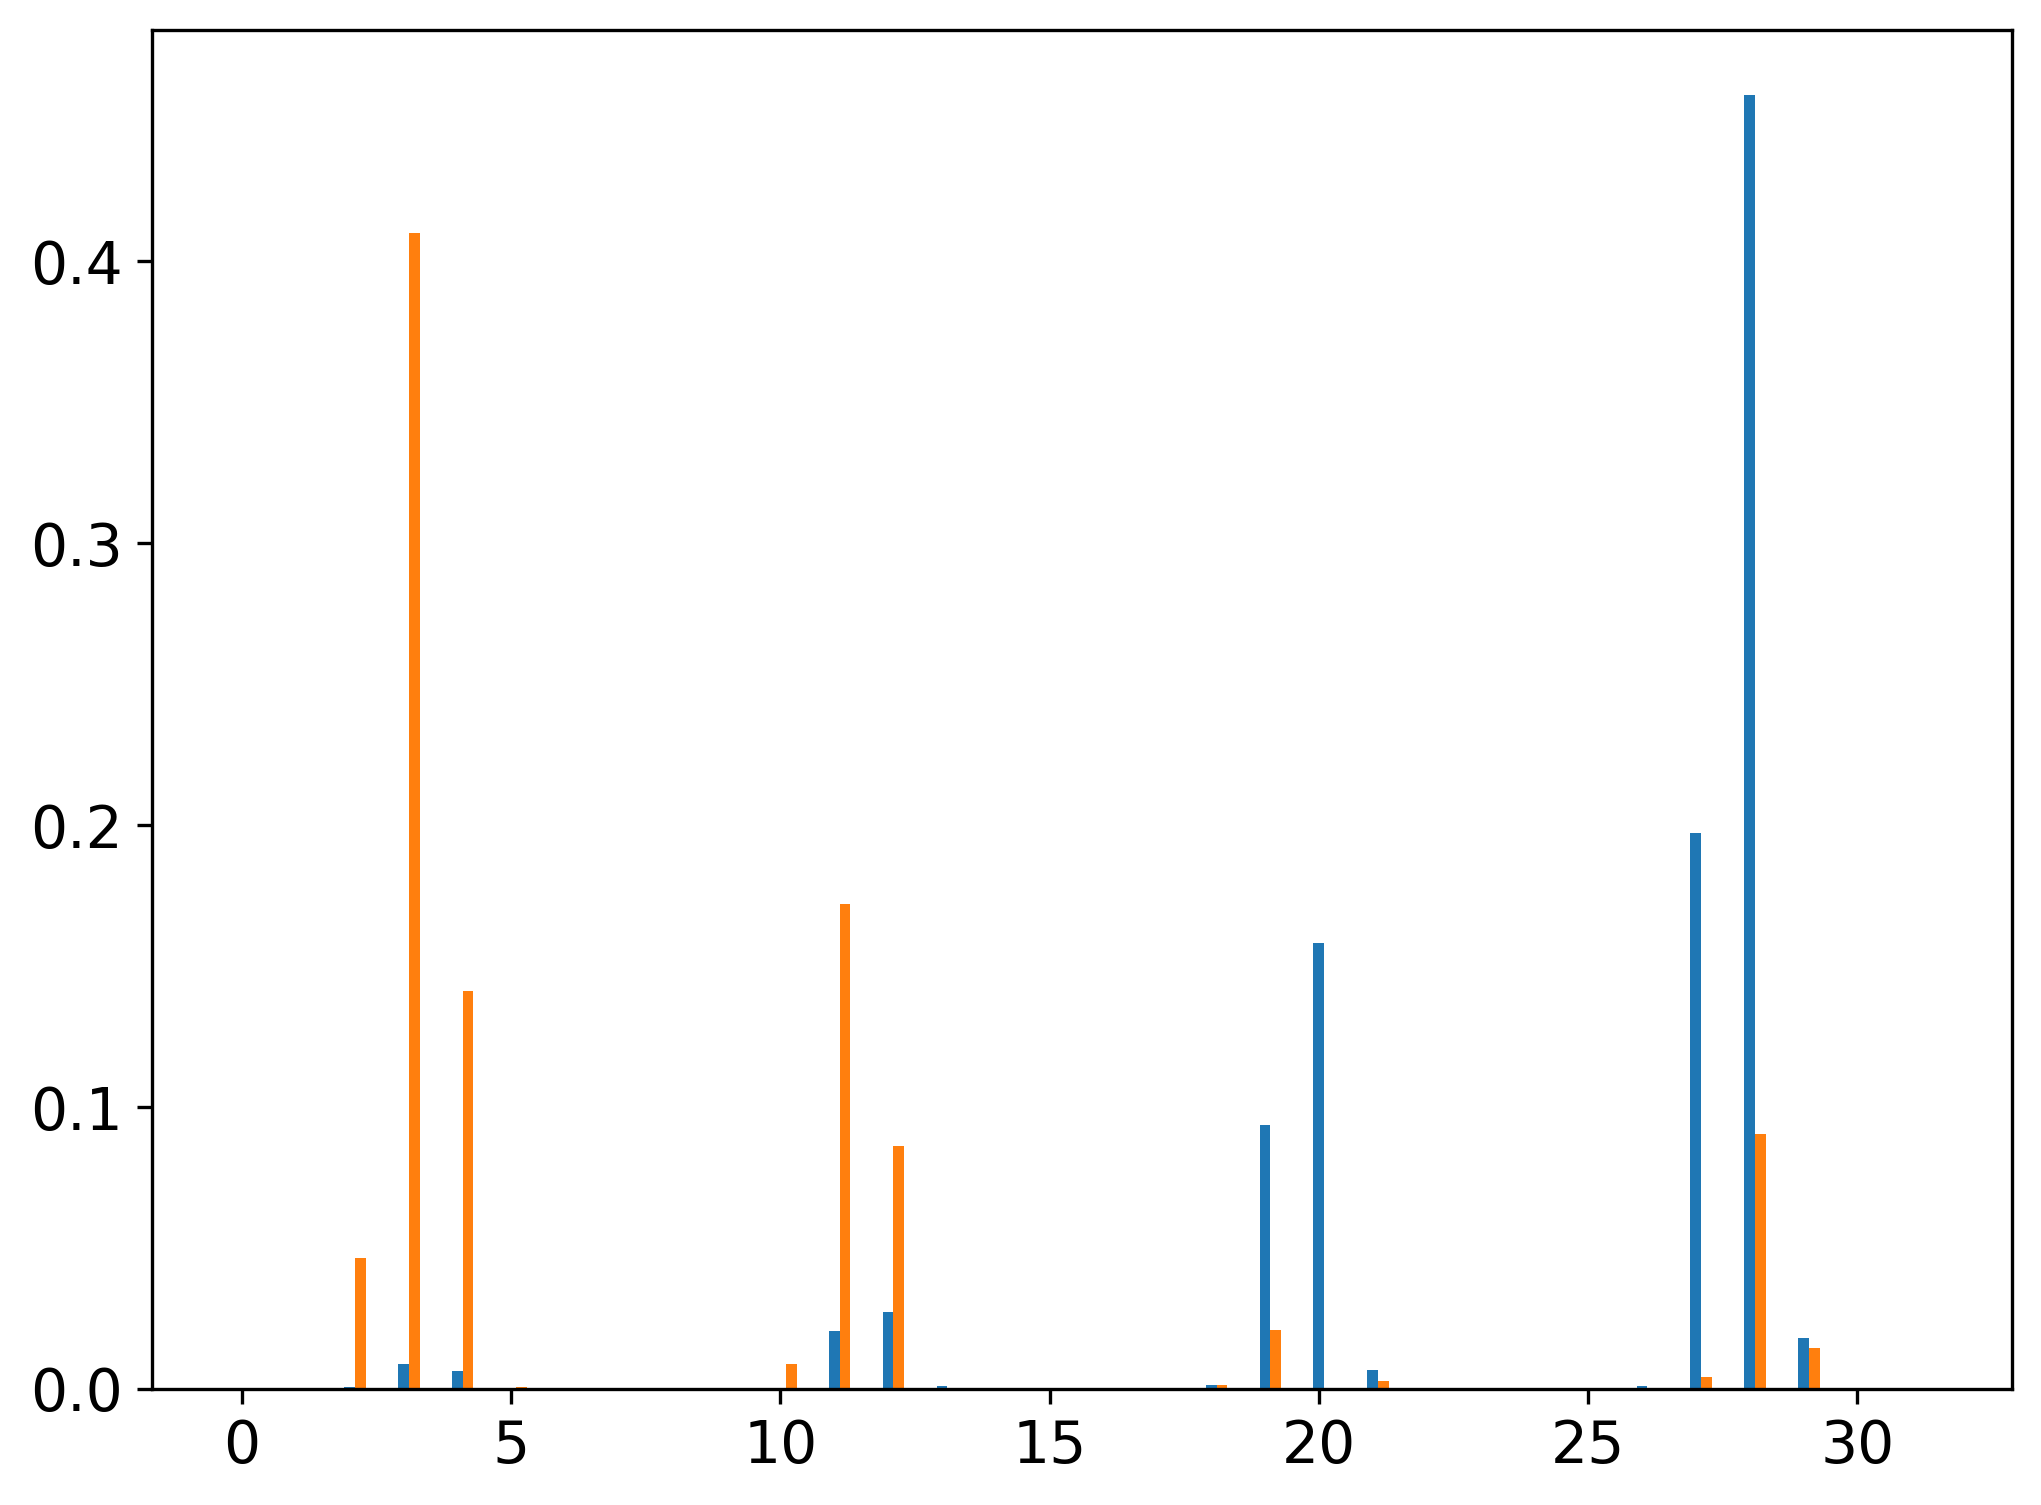

In [5]:
plt.bar(np.array(range(eigvecs.shape[1])), eigvecs.T[0]**2, width=0.2)
plt.bar(np.array(range(eigvecs.shape[1])) + 0.2, eigvecs.T[1]**2, width=0.2)

In [6]:
h_dvr_pauli = pauli_decompose(h_dvr)

np.allclose(h_dvr, h_dvr_pauli.to_matrix())

print(h_dvr.shape)
print(h_dvr_pauli.coeffs.shape)
# print(h_dvr_pauli)

c:\Users\kasna\OneDrive - UBC\arc\root\project\dvr_vqe\2d\lib\utils.py:51: ComplexWarning: Casting complex values to real discards the imaginary part
  coefs[i] = np.trace(np.dot(p.to_matrix(), h)) / 2**num_qubits


(32, 32)
(172,)


16


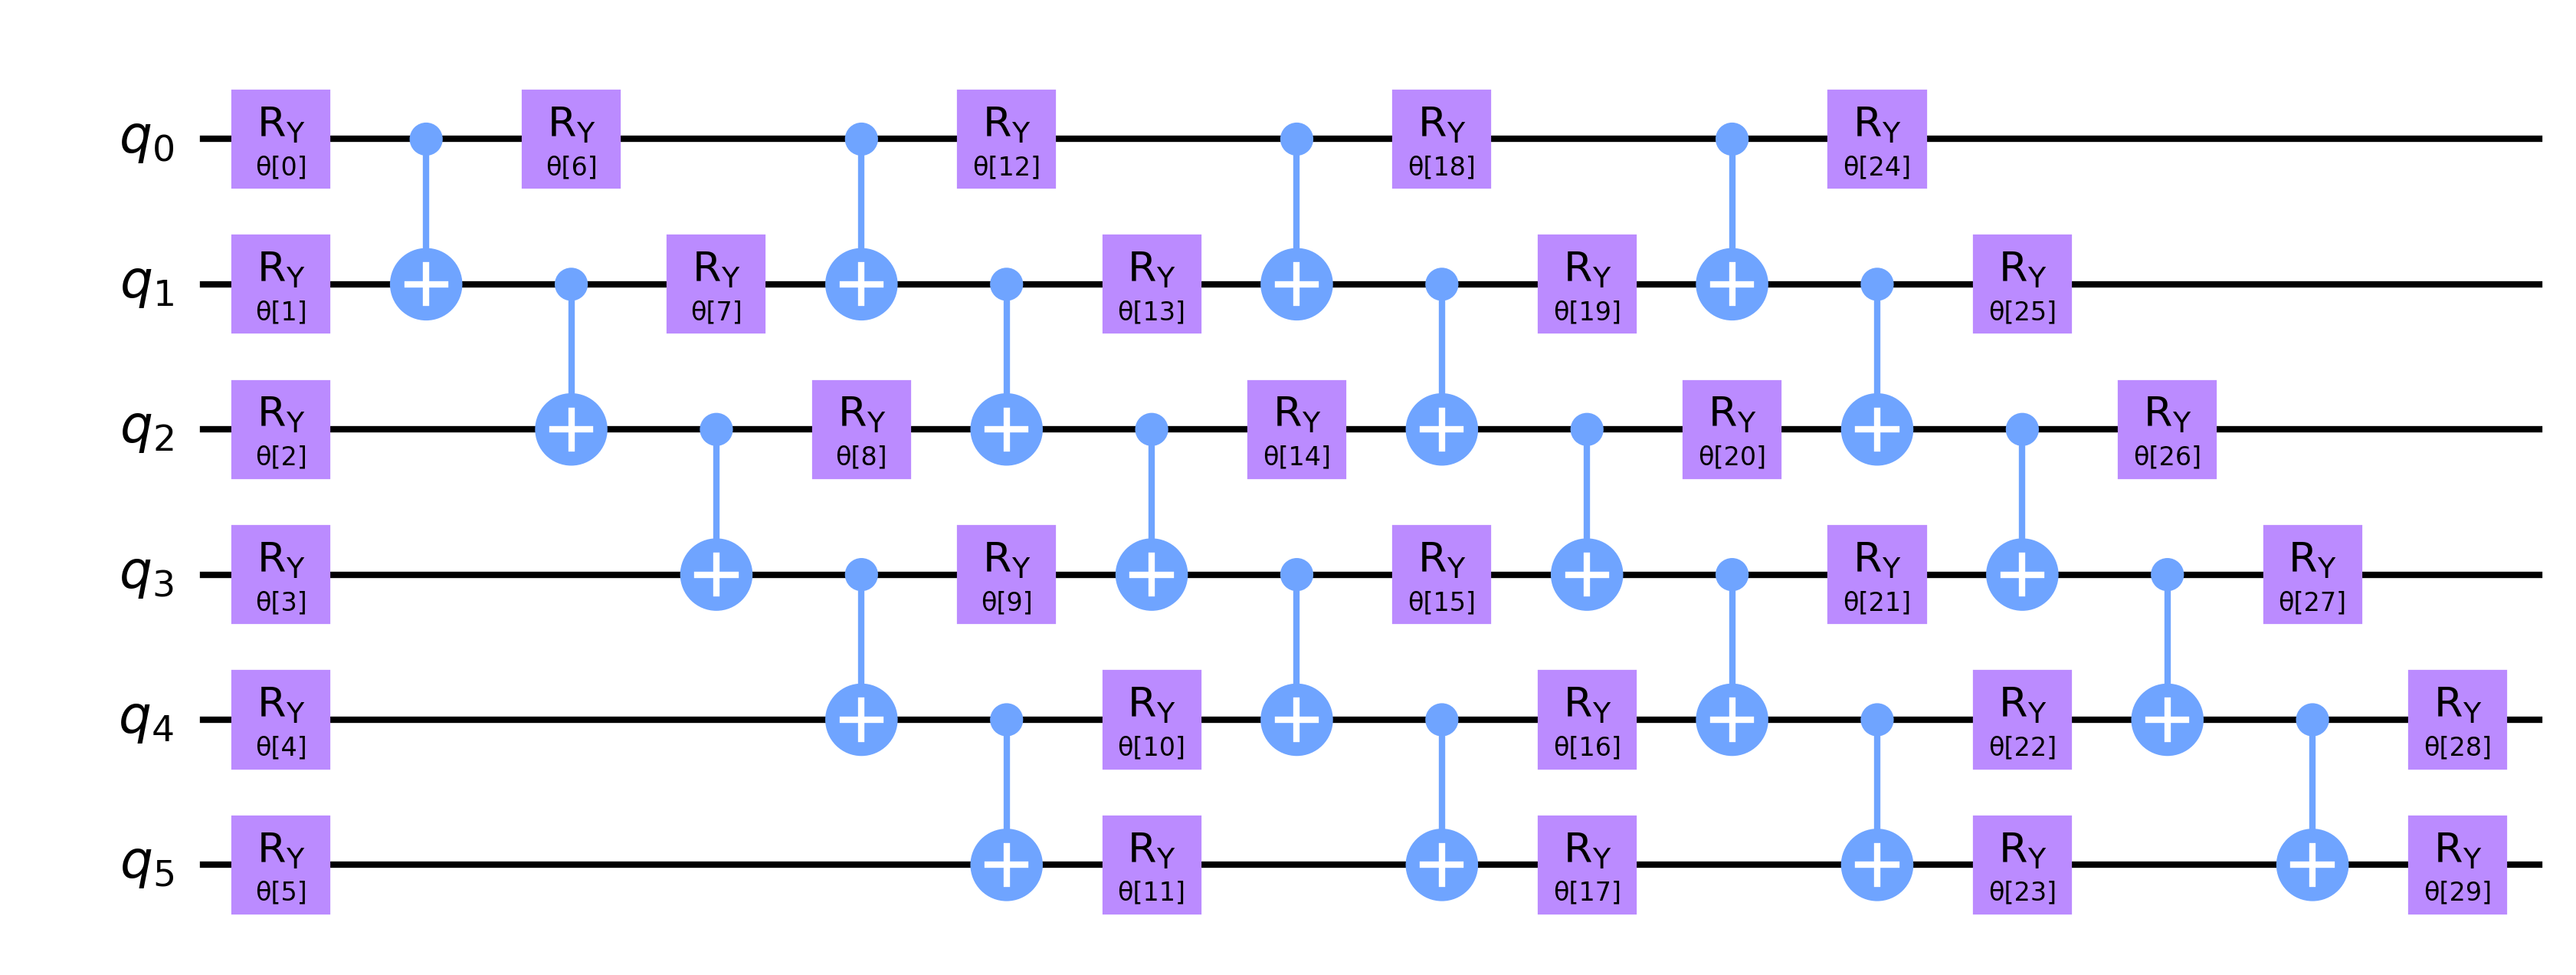

In [16]:
ansatz1 = TwoLocal(6, rotation_blocks=['ry'], entanglement_blocks='cx', entanglement='linear', reps=4).decompose()
print(ansatz1.depth())
ansatz1.draw(output='mpl', fold=-1)
# print(ansatz)

In [18]:
optimizers = [COBYLA(maxiter=8000), L_BFGS_B(maxfun=8000), SLSQP(maxiter=1000)]
# from qiskit.algorithms.optimizers import NELDER_MEAD
# optimizers = [SLSQP(maxiter=600)]
converge_cnts1 = np.empty([len(optimizers)], dtype=object)
converge_vals1 = np.empty([len(optimizers)], dtype=object)

repeat = 3
params = None
best_params1 = []
best_energies1 = []
# params = np.array([0.0 for i in range(ansatz1.num_parameters)])
for i, optimizer in enumerate(optimizers):
    print('Optimizer: {}        '.format(type(optimizer).__name__))
    algorithm_globals.random_seed = 42

    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
        print(f'\r{eval_count}, {mean}', end='')
    
    best_res1 = None
    for j in range(repeat):
        counts = []
        values = []
        vqe = VQE(ansatz1, optimizer, callback=store_intermediate_result, initial_point=params, 
                quantum_instance=QuantumInstance(backend=Aer.get_backend('statevector_simulator')))
        result = vqe.compute_minimum_eigenvalue(operator=h_dvr_pauli)
        print()

        if (best_res1 is None) or (values[-1] < best_res1):
            best_res1 = values[-1]
            best_params = result.optimal_point
            converge_cnts1[i] = np.asarray(counts)
            converge_vals1[i] = np.asarray(values)
    best_energies1.append(best_res1)
    best_params1.append(best_params)
print('\nOptimization complete      ')

Optimizer: COBYLA        
6349, -107.92099483407064
7920, -77.46834076490119
8000, -113.81245264888169
Optimizer: L_BFGS_B        
8029, -115.01583917348291
8060, -108.13789457092892
8029, -113.87807050388179
Optimizer: SLSQP        
2532, -77.46250850687052
5934, -115.06542651595372
5090, -113.58614799156773

Optimization complete      


In [15]:
print(result.optimal_point)

[-0.72825847 -5.85196163  3.65412981  1.63024887  3.17903247 -2.02877657
 -2.66753887  2.30247127 -3.81256773 -5.60783898  5.19825463 -1.57554862
  0.0433916   3.14558637  1.89047361 -1.76056135  0.37933928 -4.7756212
 -6.30949482 -0.03283754 -4.81211087 -1.53709034  3.15330432 -3.62714152
 -6.0373071 ]


COBYLA -115.10526932927561 0.1626152429337111
L_BFGS_B -115.1566106689048 0.11127390330452158
SLSQP -115.10863129630937 0.15925327589995675
NELDER_MEAD -115.05448984723667 0.21339472497265888
0.08991874864881311


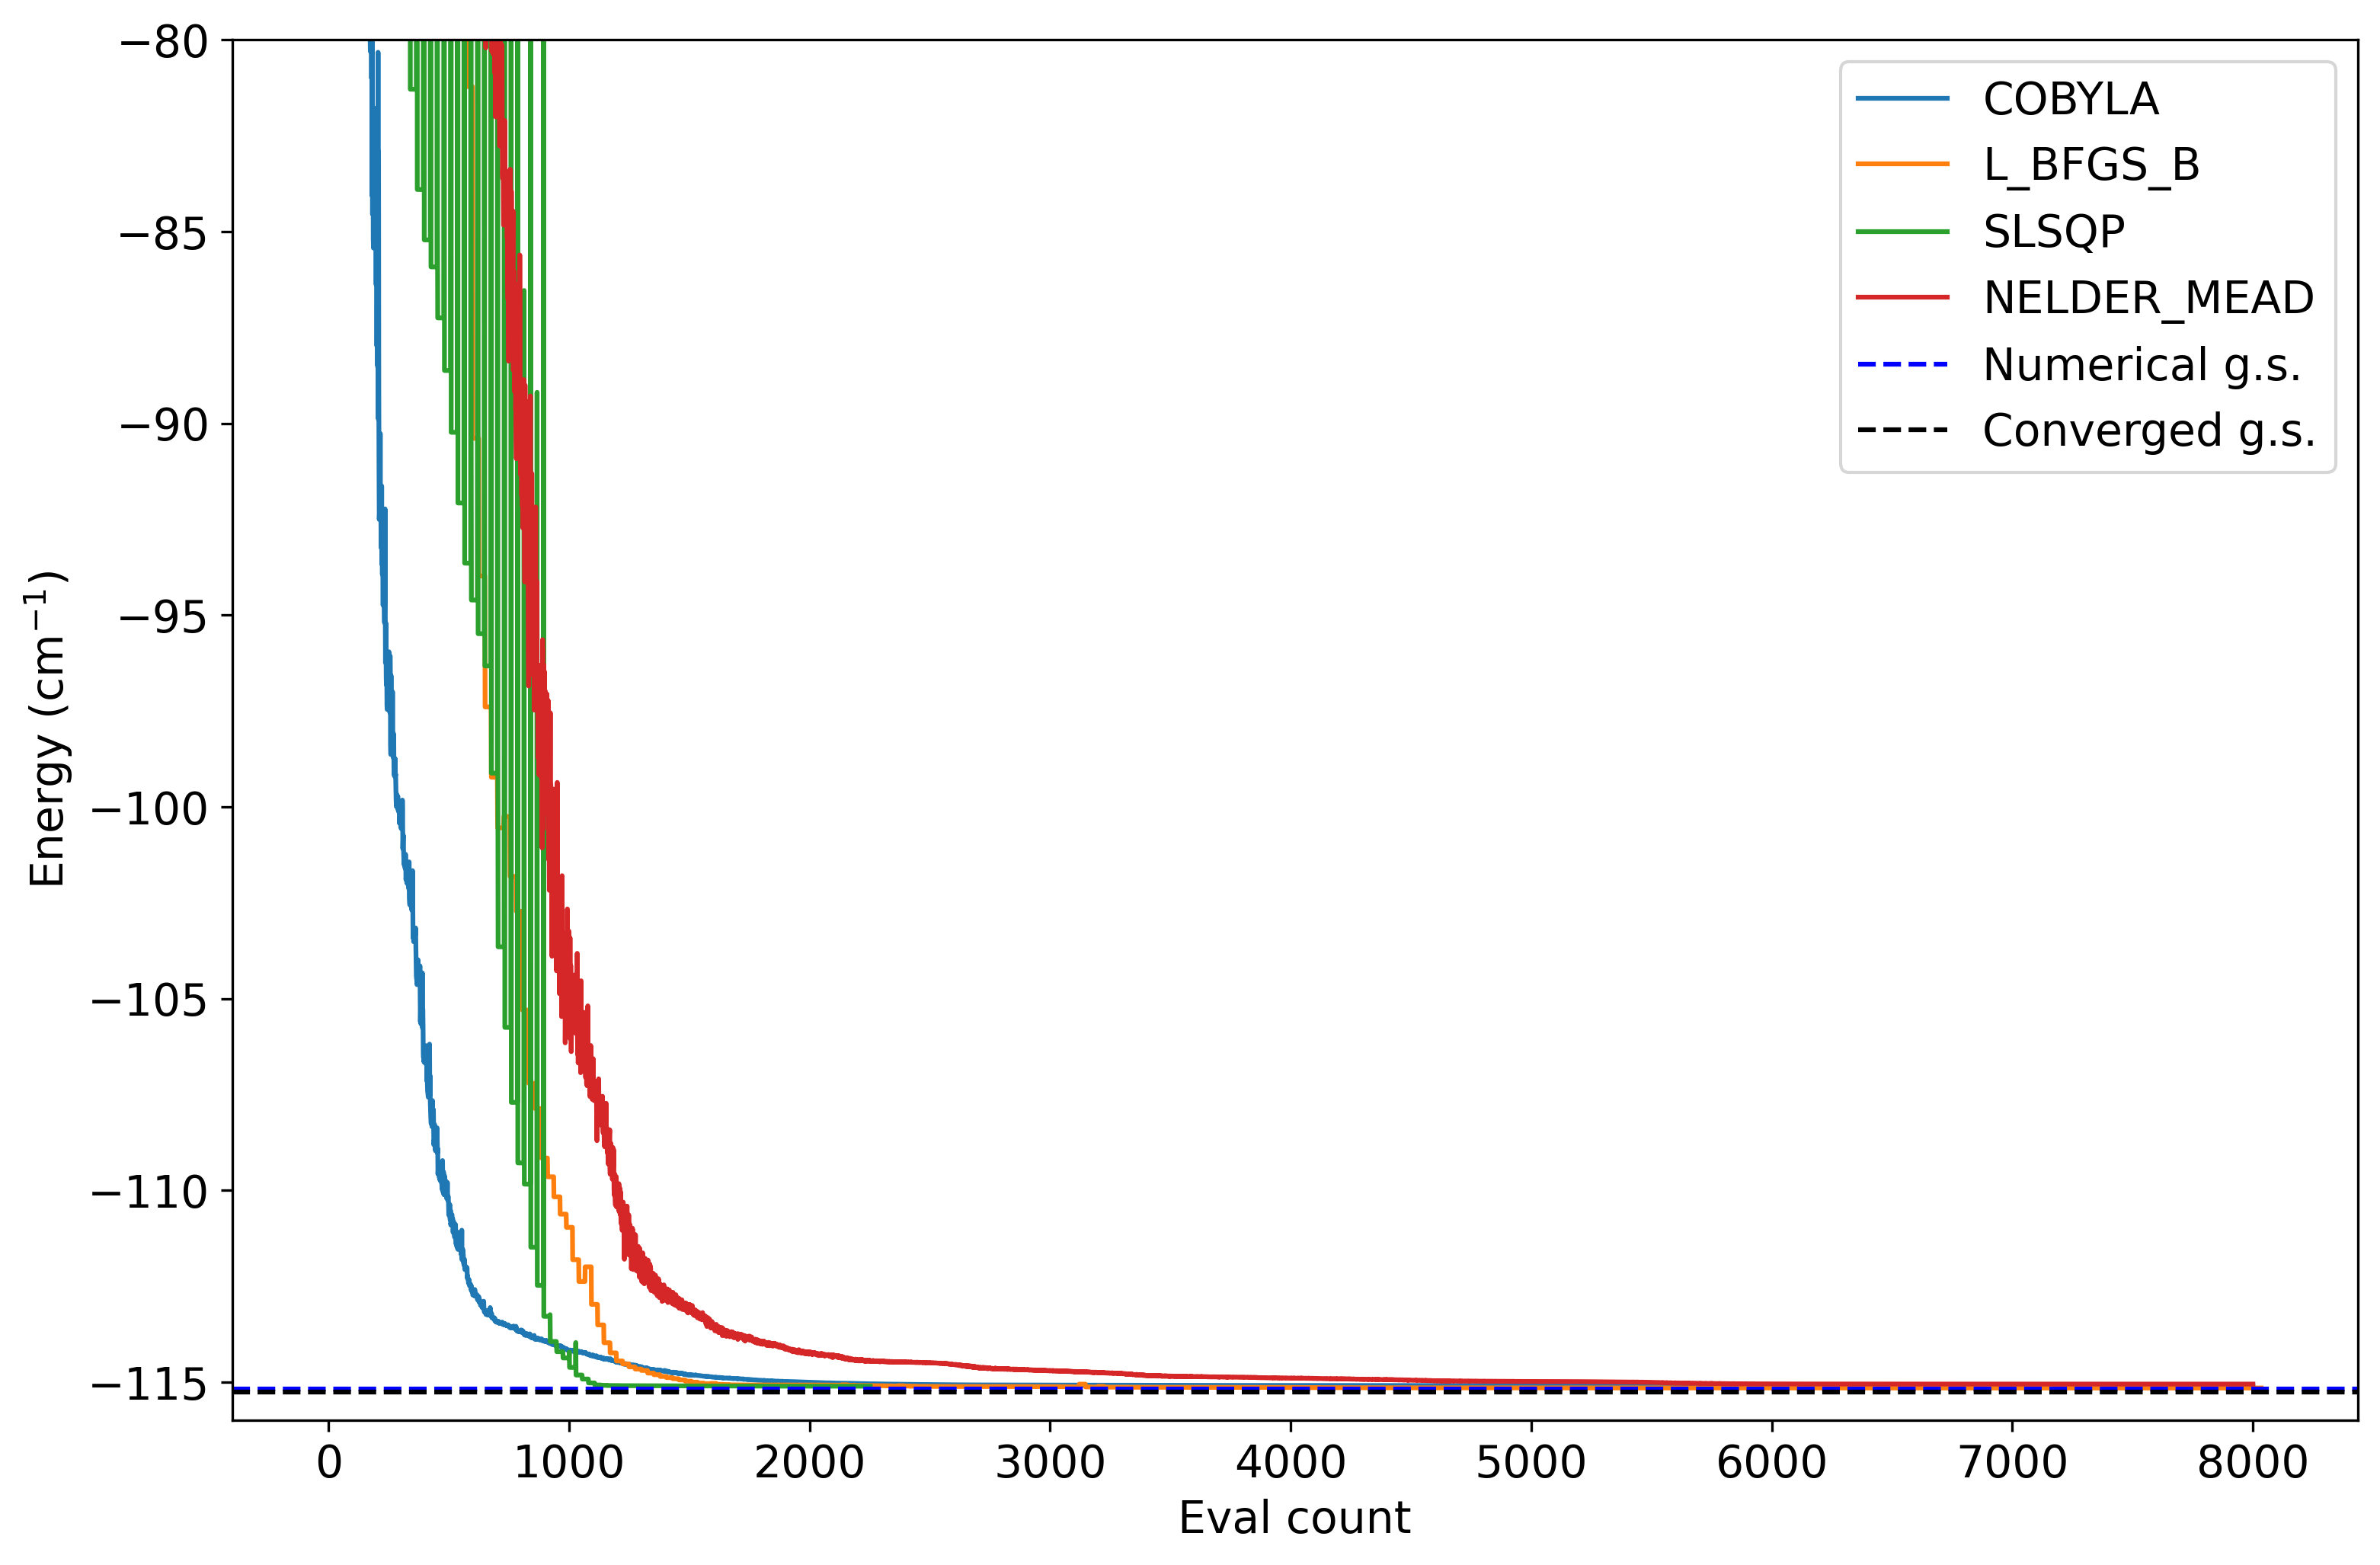

In [19]:
import pylab

ref = -115.26788457220933
# print(converge_cnts1, converge_vals1)
pylab.rcParams['figure.figsize'] = (12, 8)
for i, optimizer in enumerate(optimizers):
    print(type(optimizer).__name__, converge_vals1[i][-1], abs(ref - converge_vals1[i][-1]))
    pylab.plot(converge_cnts1[i], converge_vals1[i], label=type(optimizer).__name__)
# pylab.axhline(eigvals[0])

print(abs(ref - eigvals[0]))
pylab.axhline(eigvals[0], ls='--', c='blue', label='Numerical g.s.')
pylab.axhline(ref, ls='--', c='black', label='Converged g.s.')
pylab.xlabel('Eval count')
pylab.ylabel('Energy (cm$^{-1}$)')
# pylab.title('Energy convergence for various optimizers')
# pylab.xlim(800, 1000)
pylab.ylim(-116, -80)
pylab.legend(loc='upper right');

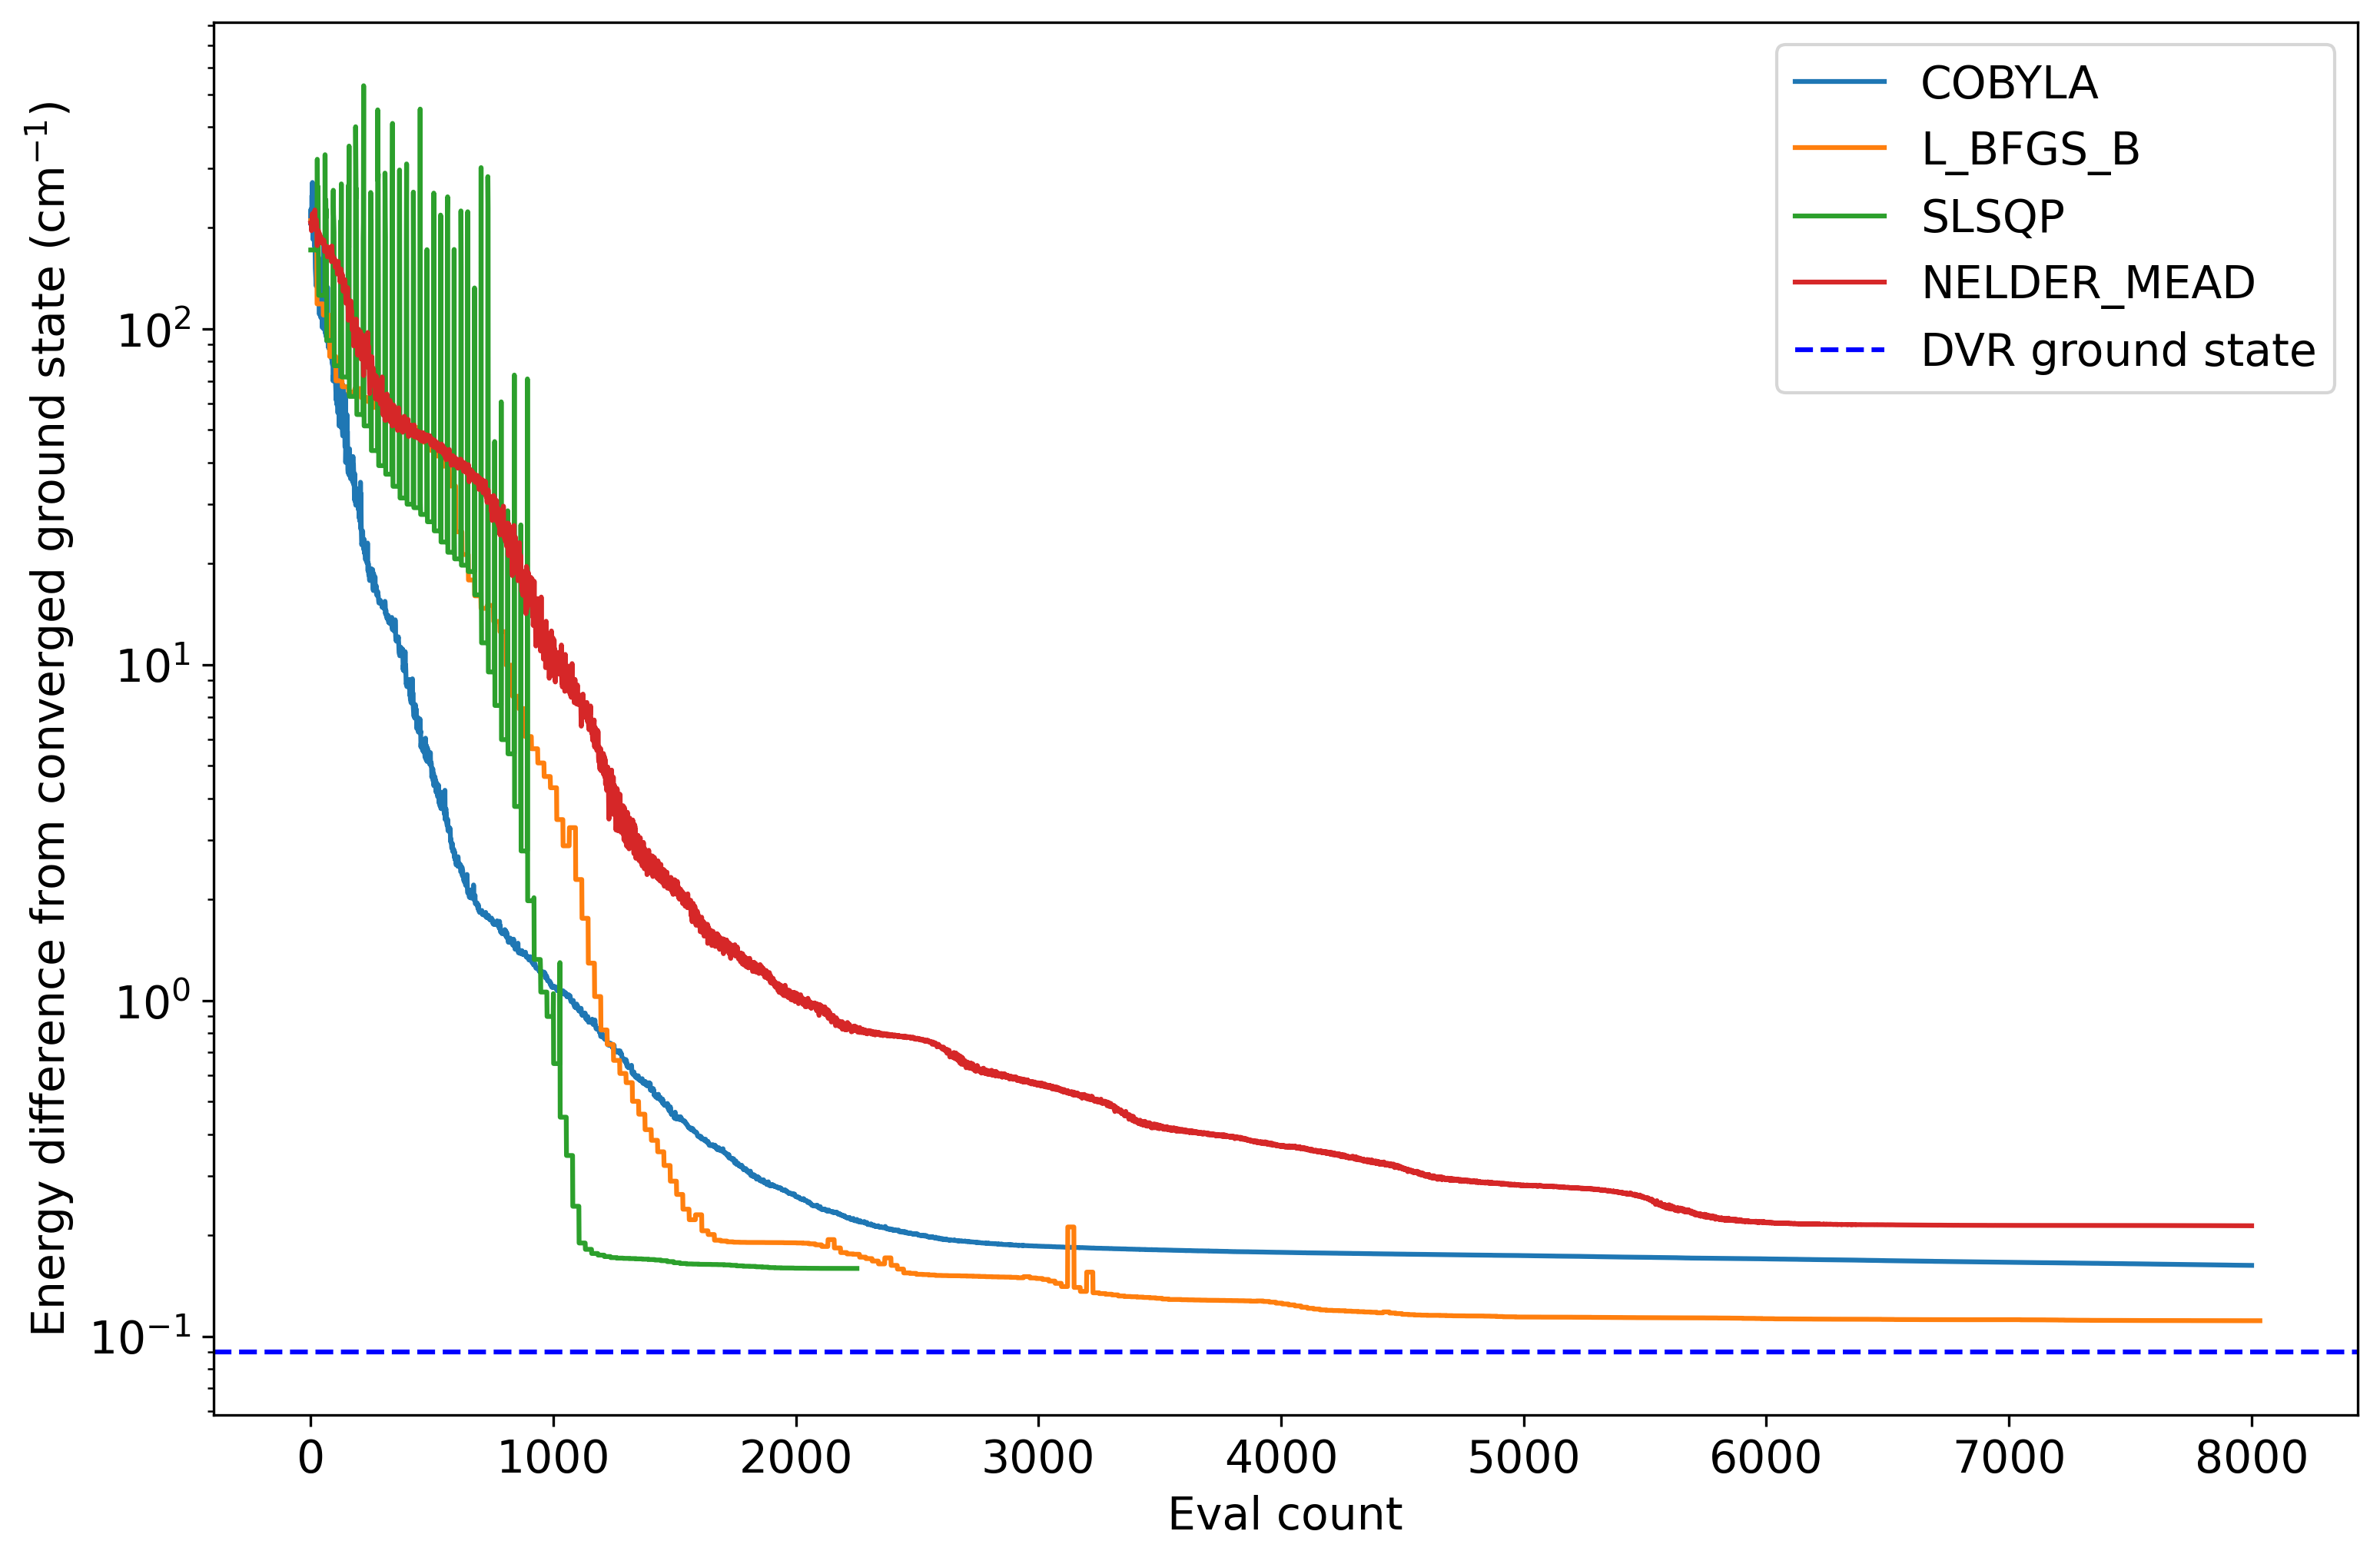

In [20]:
# pylab.rcParams['figure.figsize'] = (12, 8)
for i, optimizer in enumerate(optimizers):
    # pylab.plot(converge_cnts1[i][:], abs(ref - converge_vals1[i][:]), label=type(optimizer).__name__)
    pylab.plot(converge_cnts1[i][:], abs(ref - converge_vals1[i][:]), label=type(optimizer).__name__)
pylab.axhline(abs(ref - eigvals[0]), ls='--', c='blue', label='DVR ground state')
pylab.xlabel('Eval count')
pylab.ylabel('Energy difference from converged ground state (cm$^{-1}$)')
# pylab.title('Energy convergence for various optimizers')
pylab.yscale('log')
# plt.ylim(0,1)
pylab.legend(loc='upper right');
# print(abs(ref - converge_vals1[:, -1]))

In [23]:
opt_p = best_params1[np.argmin(best_energies1)]
# print(p)
backend = Aer.get_backend('statevector_simulator')
# print(overlap.real**2 + overlap.imag**2)

def cost_function(p, beta, vqe):
    e = vqe.get_energy_evaluation(h_dvr_pauli)(p)
    gs = ansatz1.assign_parameters(opt_p)
    c = ansatz1.assign_parameters(p)
    circ = gs.compose(c.inverse())
    result = backend.run(circ).result()
    sv = result.get_statevector()
    # overlap = gs.inner(c.conjugate())
    return e + beta * sv.probabilities()[0]

a = cost_function(opt_p, 40, vqe)
print()
b = cost_function(np.random.rand(ansatz1.num_parameters) * 2 * np.pi, 40, vqe)
print()
print(a)
print(b)

8003, -115.15661066893742
8004, 136.6330211703612
-75.15661066893746
137.3482482696072


In [24]:
optimizers = [COBYLA(maxiter=8000), L_BFGS_B(maxfun=8000), SLSQP(maxiter=1000), NELDER_MEAD(maxfev=8000)]
# optimizers = [SLSQP(maxiter=1000)]
converge_cnts2 = np.empty([len(optimizers)], dtype=object)
converge_vals2 = np.empty([len(optimizers)], dtype=object)

repeat = 3
params = None
best_energies2 = []
best_params2 = []
backend = Aer.get_backend('statevector_simulator')
beta = 100
# params = np.array([0.0 for i in range(ansatz1.num_parameters)])
for i, optimizer in enumerate(optimizers):
    print('Optimizer: {}        '.format(type(optimizer).__name__))
    algorithm_globals.random_seed = 42

    def store_intermediate_result(eval_count, parameters, mean, std):
        global evals
        evals += 1
        counts.append(evals)
        values.append(mean)
        print(f'\r{evals}, {mean}', end='')
    
    best_res2 = None
    for j in range(repeat):
        counts = []
        values = []
        evals = 0
        vqe = VQE(ansatz1, optimizer, callback=store_intermediate_result, initial_point=params, 
                quantum_instance=QuantumInstance(backend=backend))
        n_params = ansatz1.num_parameters
        result = optimizer.minimize(lambda p: cost_function(p, beta, vqe), (np.random.rand(n_params) * 2 * np.pi) if params is None else opt_p)
        print()

        if (best_res2 is None) or (values[-1] < best_res2):
            best_res2 = values[-1]
            best_params = result.x
            converge_cnts2[i] = np.asarray(counts)
            converge_vals2[i] = np.asarray(values)
    best_energies2.append(best_res2)
    best_params2.append(best_params)
print('\nOptimization complete      ')

Optimizer: COBYLA        
8000, -82.97764195176264
8000, -90.22880951464978
8000, -83.54080198063389
Optimizer: L_BFGS_B        
5532, -90.80466002604777

KeyboardInterrupt: 

In [58]:
print(cost_function(result.x, beta, vqe))
vqe.get_energy_evaluation(h_dvr_pauli)(result.x)

1108, -89.68767179783816-89.57684855629431
1109, -89.68767179783816

-89.68767179783816

In [59]:
-89.68767179783816 - -115.0341642801133

25.34649248227514

COBYLA -82.80991437678335 23.379882823551682
L_BFGS_B -89.62937191902603 23.403048440066527
SLSQP -89.59512648211721 23.403048229443797
NELDER_MEAD -78.40533264008045 23.345724752415734
0.6856754824934939


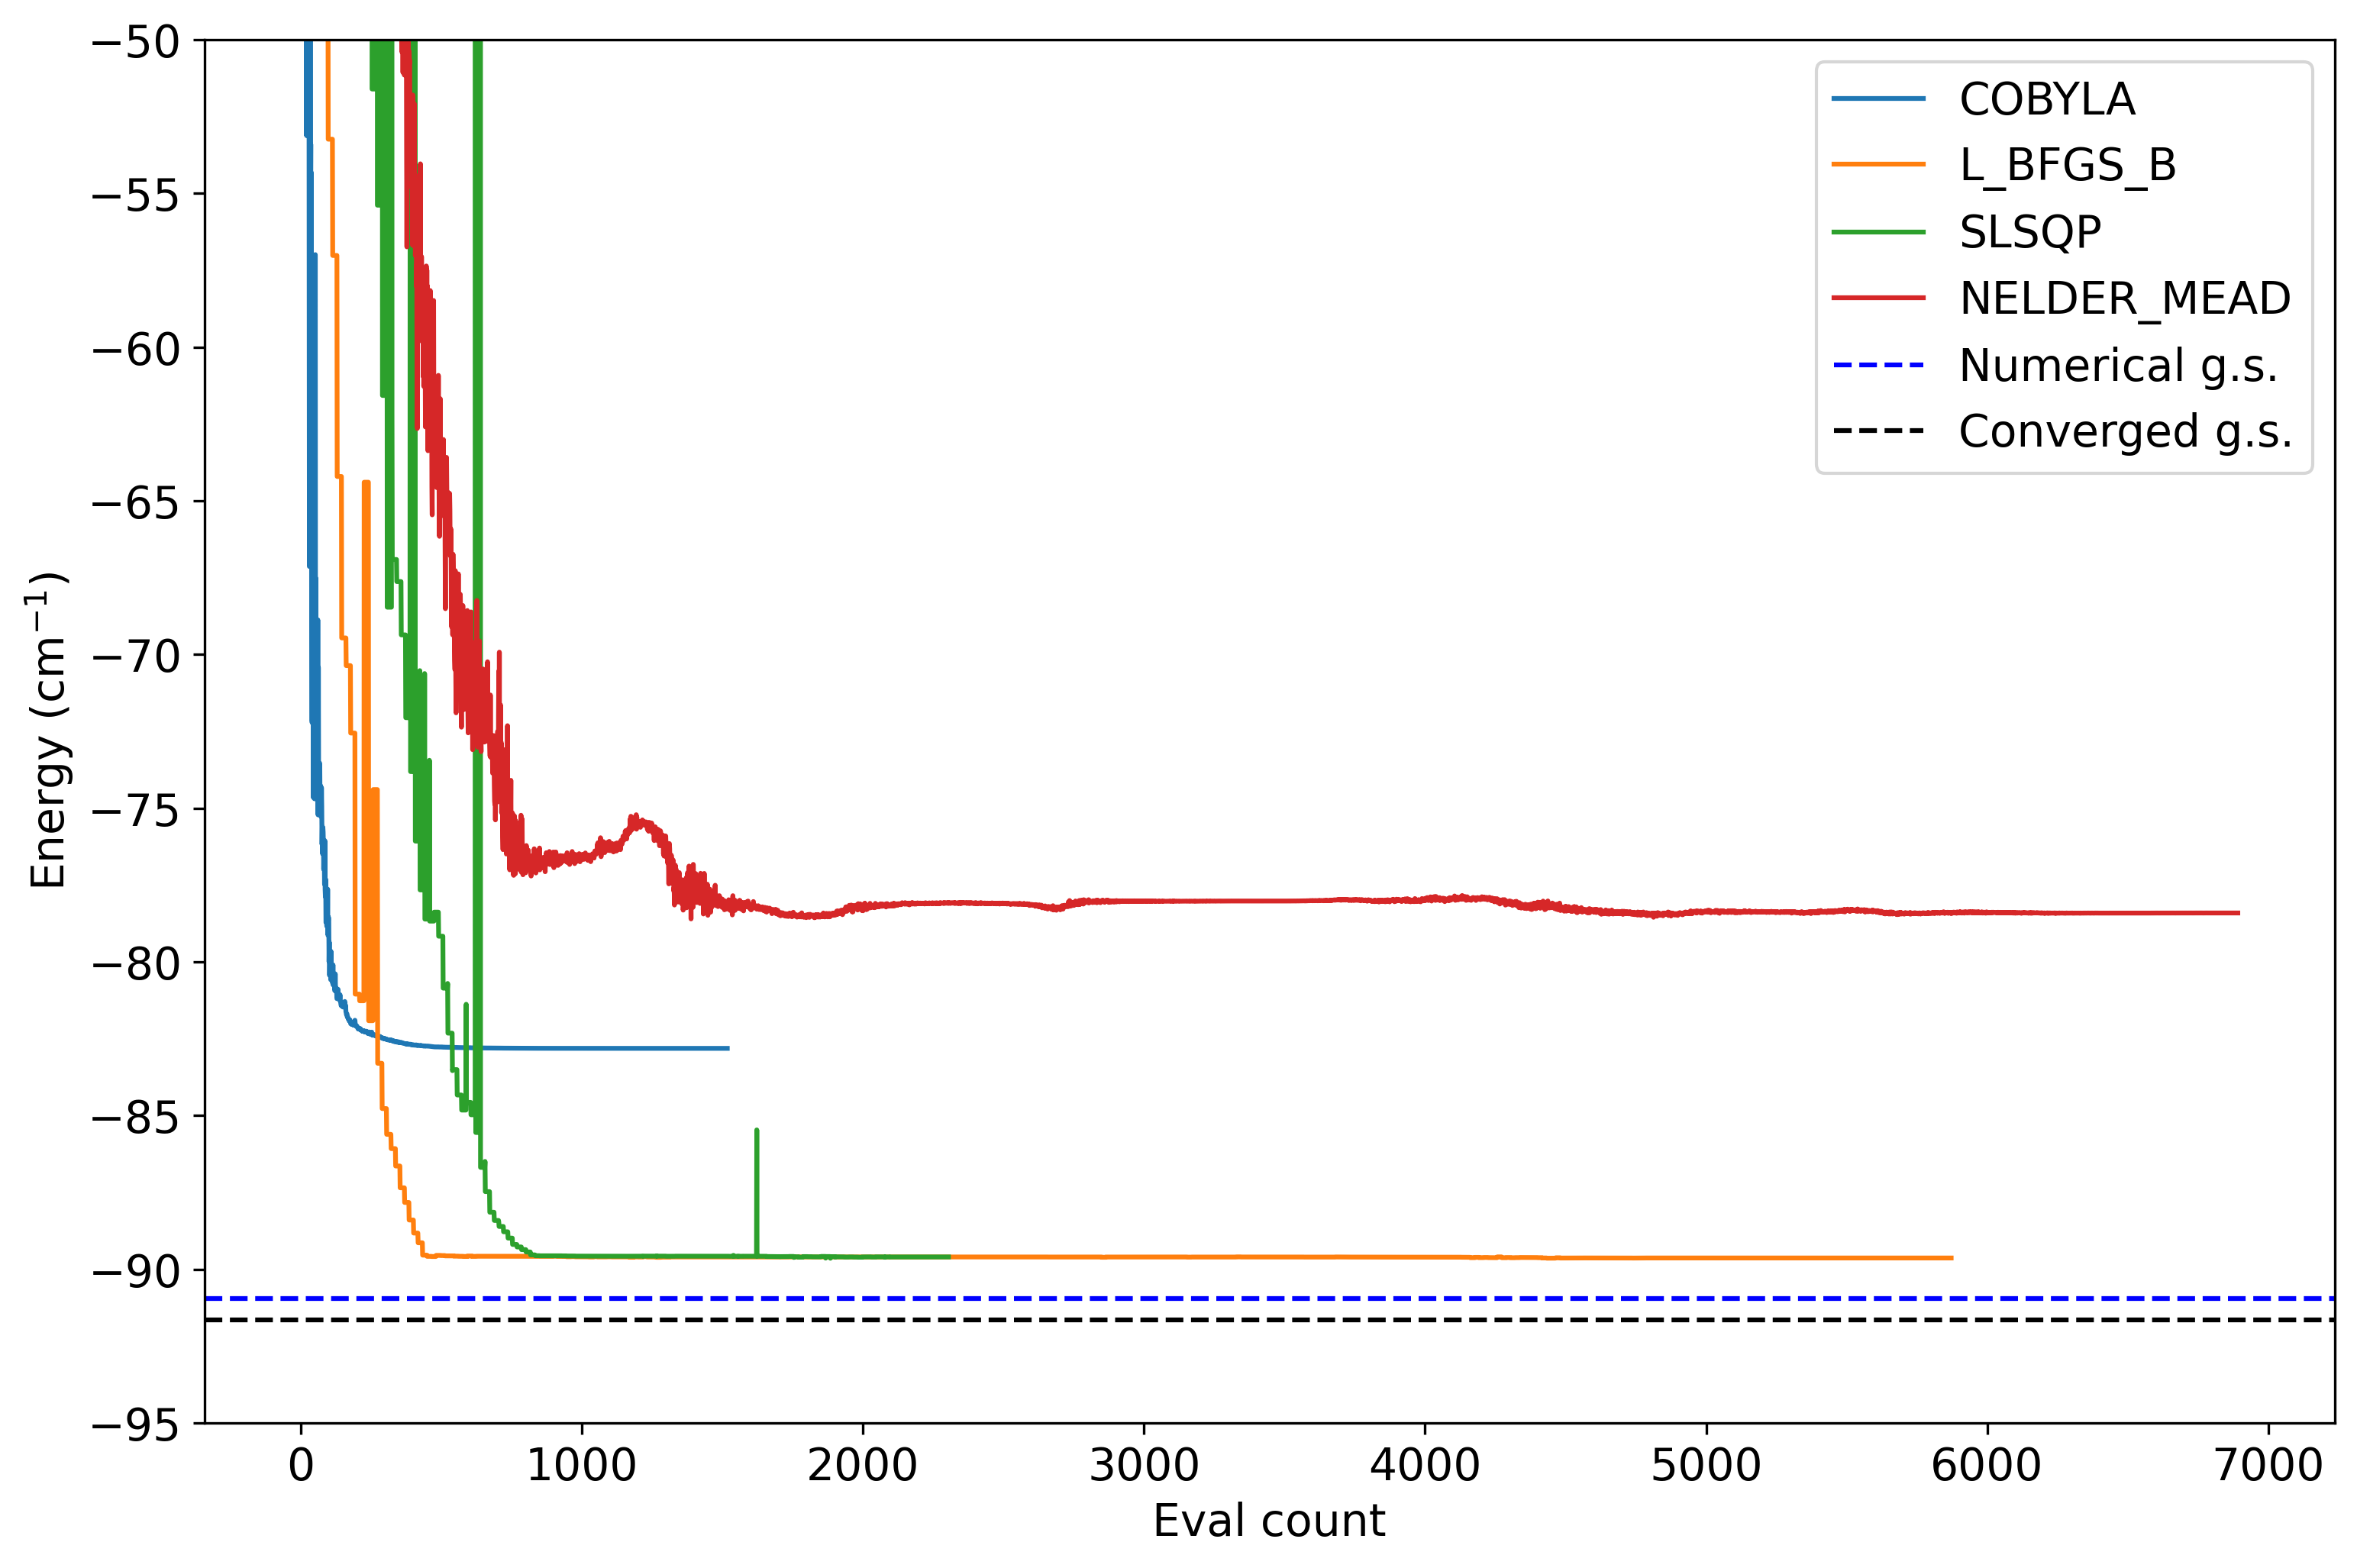

In [27]:
import pylab

ref = -91.64465974
# print(converge_cnts1, converge_vals1)
pylab.rcParams['figure.figsize'] = (12, 8)
for i, optimizer in enumerate(optimizers):
    print(type(optimizer).__name__, converge_vals2[i][-1], abs(ref - converge_vals1[i][-1]))
    pylab.plot(converge_cnts2[i], converge_vals2[i], label=type(optimizer).__name__)
# pylab.axhline(eigvals[0])

print(abs(ref - eigvals[1]))
pylab.axhline(eigvals[1], ls='--', c='blue', label='Numerical g.s.')
pylab.axhline(ref, ls='--', c='black', label='Converged g.s.')
pylab.xlabel('Eval count')
pylab.ylabel('Energy (cm$^{-1}$)')
# pylab.title('Energy convergence for various optimizers')
# pylab.xlim(800, 1000)
pylab.ylim(-95, -50)
pylab.legend(loc='upper right');

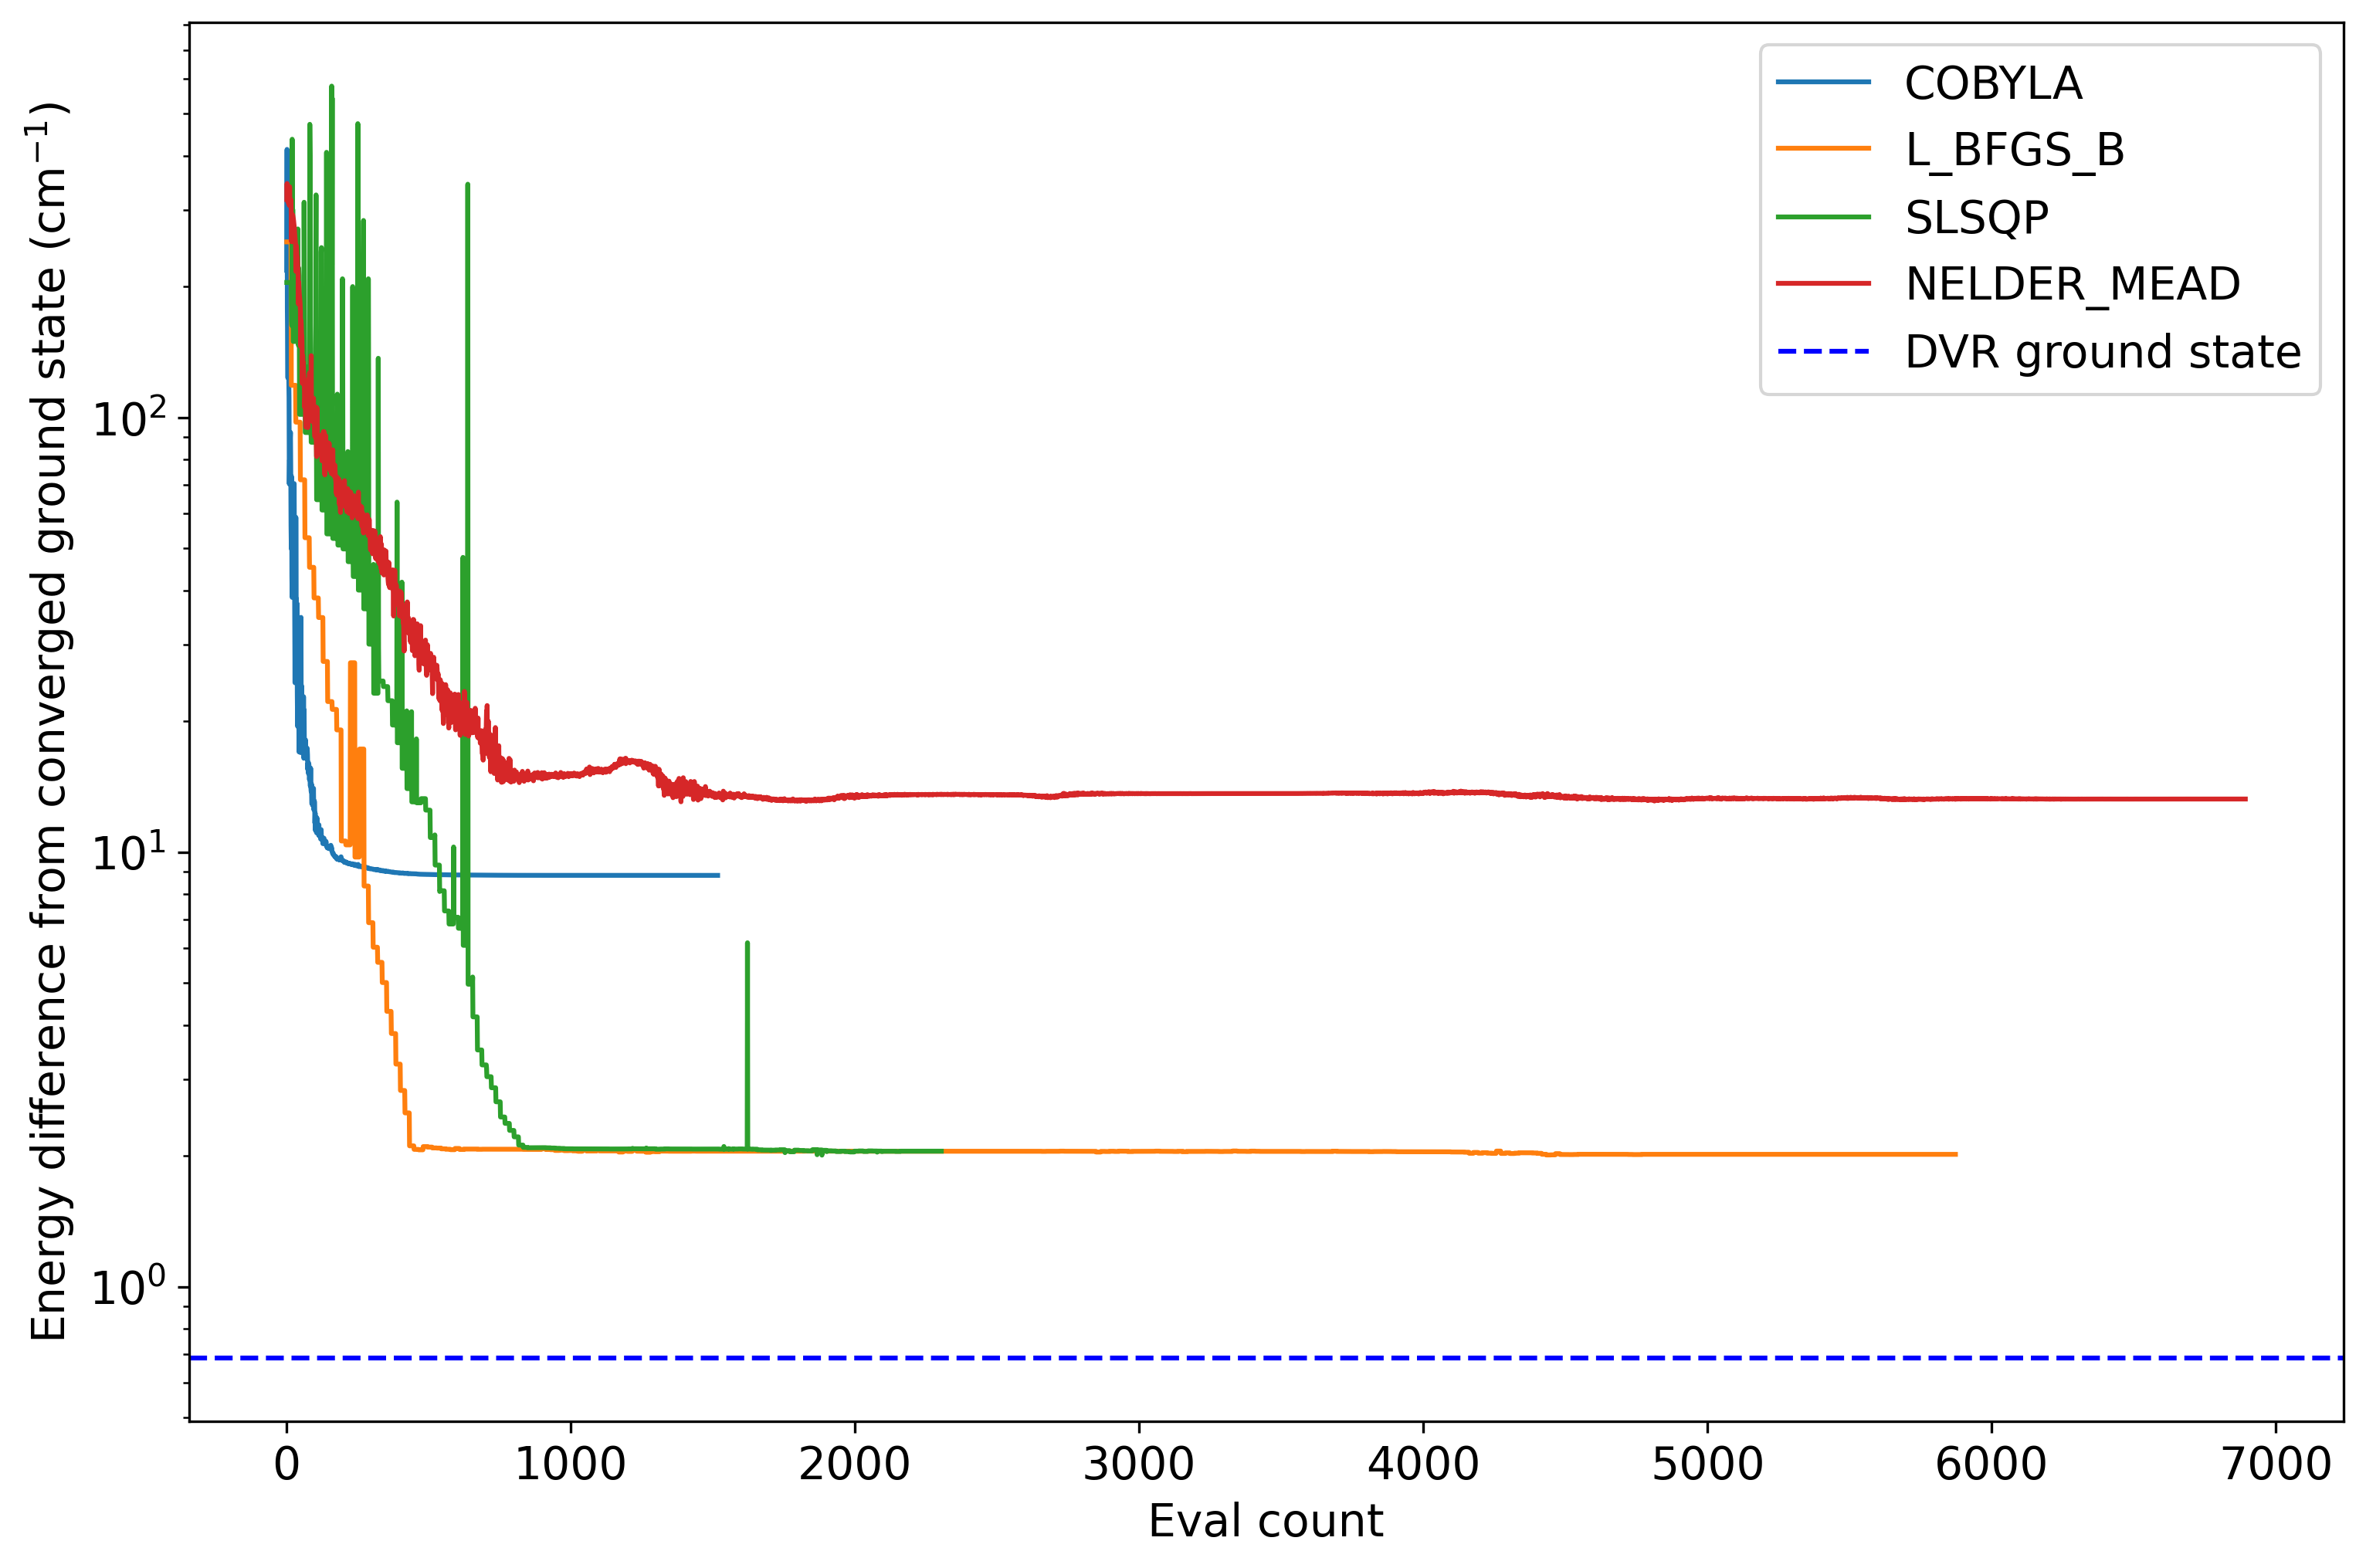

In [30]:
# pylab.rcParams['figure.figsize'] = (12, 8)
for i, optimizer in enumerate(optimizers):
    # pylab.plot(converge_cnts1[i][:], abs(ref - converge_vals1[i][:]), label=type(optimizer).__name__)
    pylab.plot(converge_cnts2[i][:], abs(ref - converge_vals2[i][:]), label=type(optimizer).__name__)
pylab.axhline(abs(ref - eigvals[1]), ls='--', c='blue', label='DVR ground state')
pylab.xlabel('Eval count')
pylab.ylabel('Energy difference from converged ground state (cm$^{-1}$)')
# pylab.title('Energy convergence for various optimizers')
pylab.yscale('log')
# plt.ylim(0,1)
pylab.legend(loc='upper right');
# print(abs(ref - converge_vals1[:, -1]))

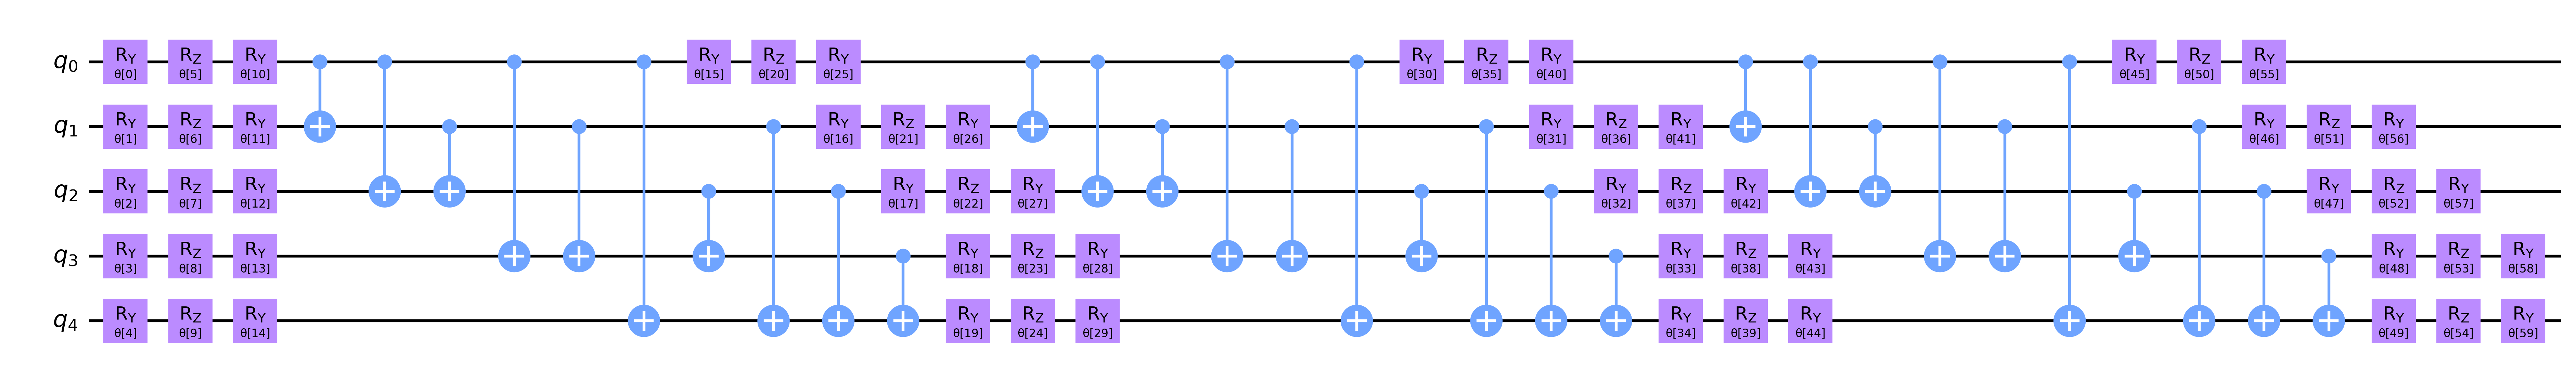

In [37]:
ansatz2 = TwoLocal(5, rotation_blocks=['ry', 'rz', 'ry'], entanglement_blocks='cx', entanglement='full', reps=3).decompose()
ansatz2.draw(output='mpl', fold=-1)
# print(ansatz)

In [38]:
h_dvr_pauli = pauli_decompose(h_dvr)

np.allclose(h_dvr, h_dvr_pauli.to_matrix())

print(h_dvr.shape)
print(h_dvr_pauli.coeffs.shape)
# print(h_dvr_pauli)

/Users/user/Library/CloudStorage/OneDrive-UBC/arc/root/project/dvr_vqe/2d/dvr2d.py:75: ComplexWarning: Casting complex values to real discards the imaginary part
  coefs[i] = np.trace(np.dot(p.to_matrix(), h)) / 2**num_qubits


(32, 32)
(172,)


In [42]:
optimizers = [COBYLA(maxiter=8000), L_BFGS_B(maxfun=8000), SLSQP(maxiter=1000), NELDER_MEAD(maxfev=8000)]
# from qiskit.algorithms.optimizers import NELDER_MEAD
# optimizers = [SLSQP(maxiter=600)]
converge_cnts2 = np.empty([len(optimizers)], dtype=object)
converge_vals2 = np.empty([len(optimizers)], dtype=object)

repeat = 3
params = None
# params = np.array([0.0 for i in range(ansatz1.num_parameters)])
for i, optimizer in enumerate(optimizers):
    print('Optimizer: {}        '.format(type(optimizer).__name__))
    algorithm_globals.random_seed = 42

    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
        print(f'\r{eval_count}, {mean}', end='')
    
    best_res2 = None
    for j in range(repeat):
        counts = []
        values = []
        vqe = VQE(ansatz2, optimizer, callback=store_intermediate_result, initial_point=params, 
                quantum_instance=QuantumInstance(backend=Aer.get_backend('statevector_simulator')))
        result = vqe.compute_minimum_eigenvalue(operator=h_dvr_pauli)
        print()

        if (best_res2 is None) or (values[-1] < best_res2):
            best_res2 = values[-1]
            converge_cnts2[i] = np.asarray(counts)
            converge_vals2[i] = np.asarray(values)
print('\nOptimization complete      ')

Optimizer: COBYLA        
8000, -115.01637676646519
8000, -114.96394839197508
8000, -115.02419250542167
Optimizer: L_BFGS_B        
8052, -115.01814280183252
8052, -115.01846733129659
8052, -115.01941103664232
Optimizer: SLSQP        
40843, -115.16675604701412
12916, -115.10199289177774
18572, -115.10521754420786
Optimizer: NELDER_MEAD        
8000, -114.804227845114012
8000, -113.09279612551741
8000, -114.64011638884687

Optimization complete      


COBYLA -115.02419250542167 0.2436920667876592
L_BFGS_B -115.0194110366423 0.24847353556702956
SLSQP -115.10521754420786 0.16266702800146504
NELDER_MEAD -114.80422784511401 0.46365672709531225
0.08991874864886995


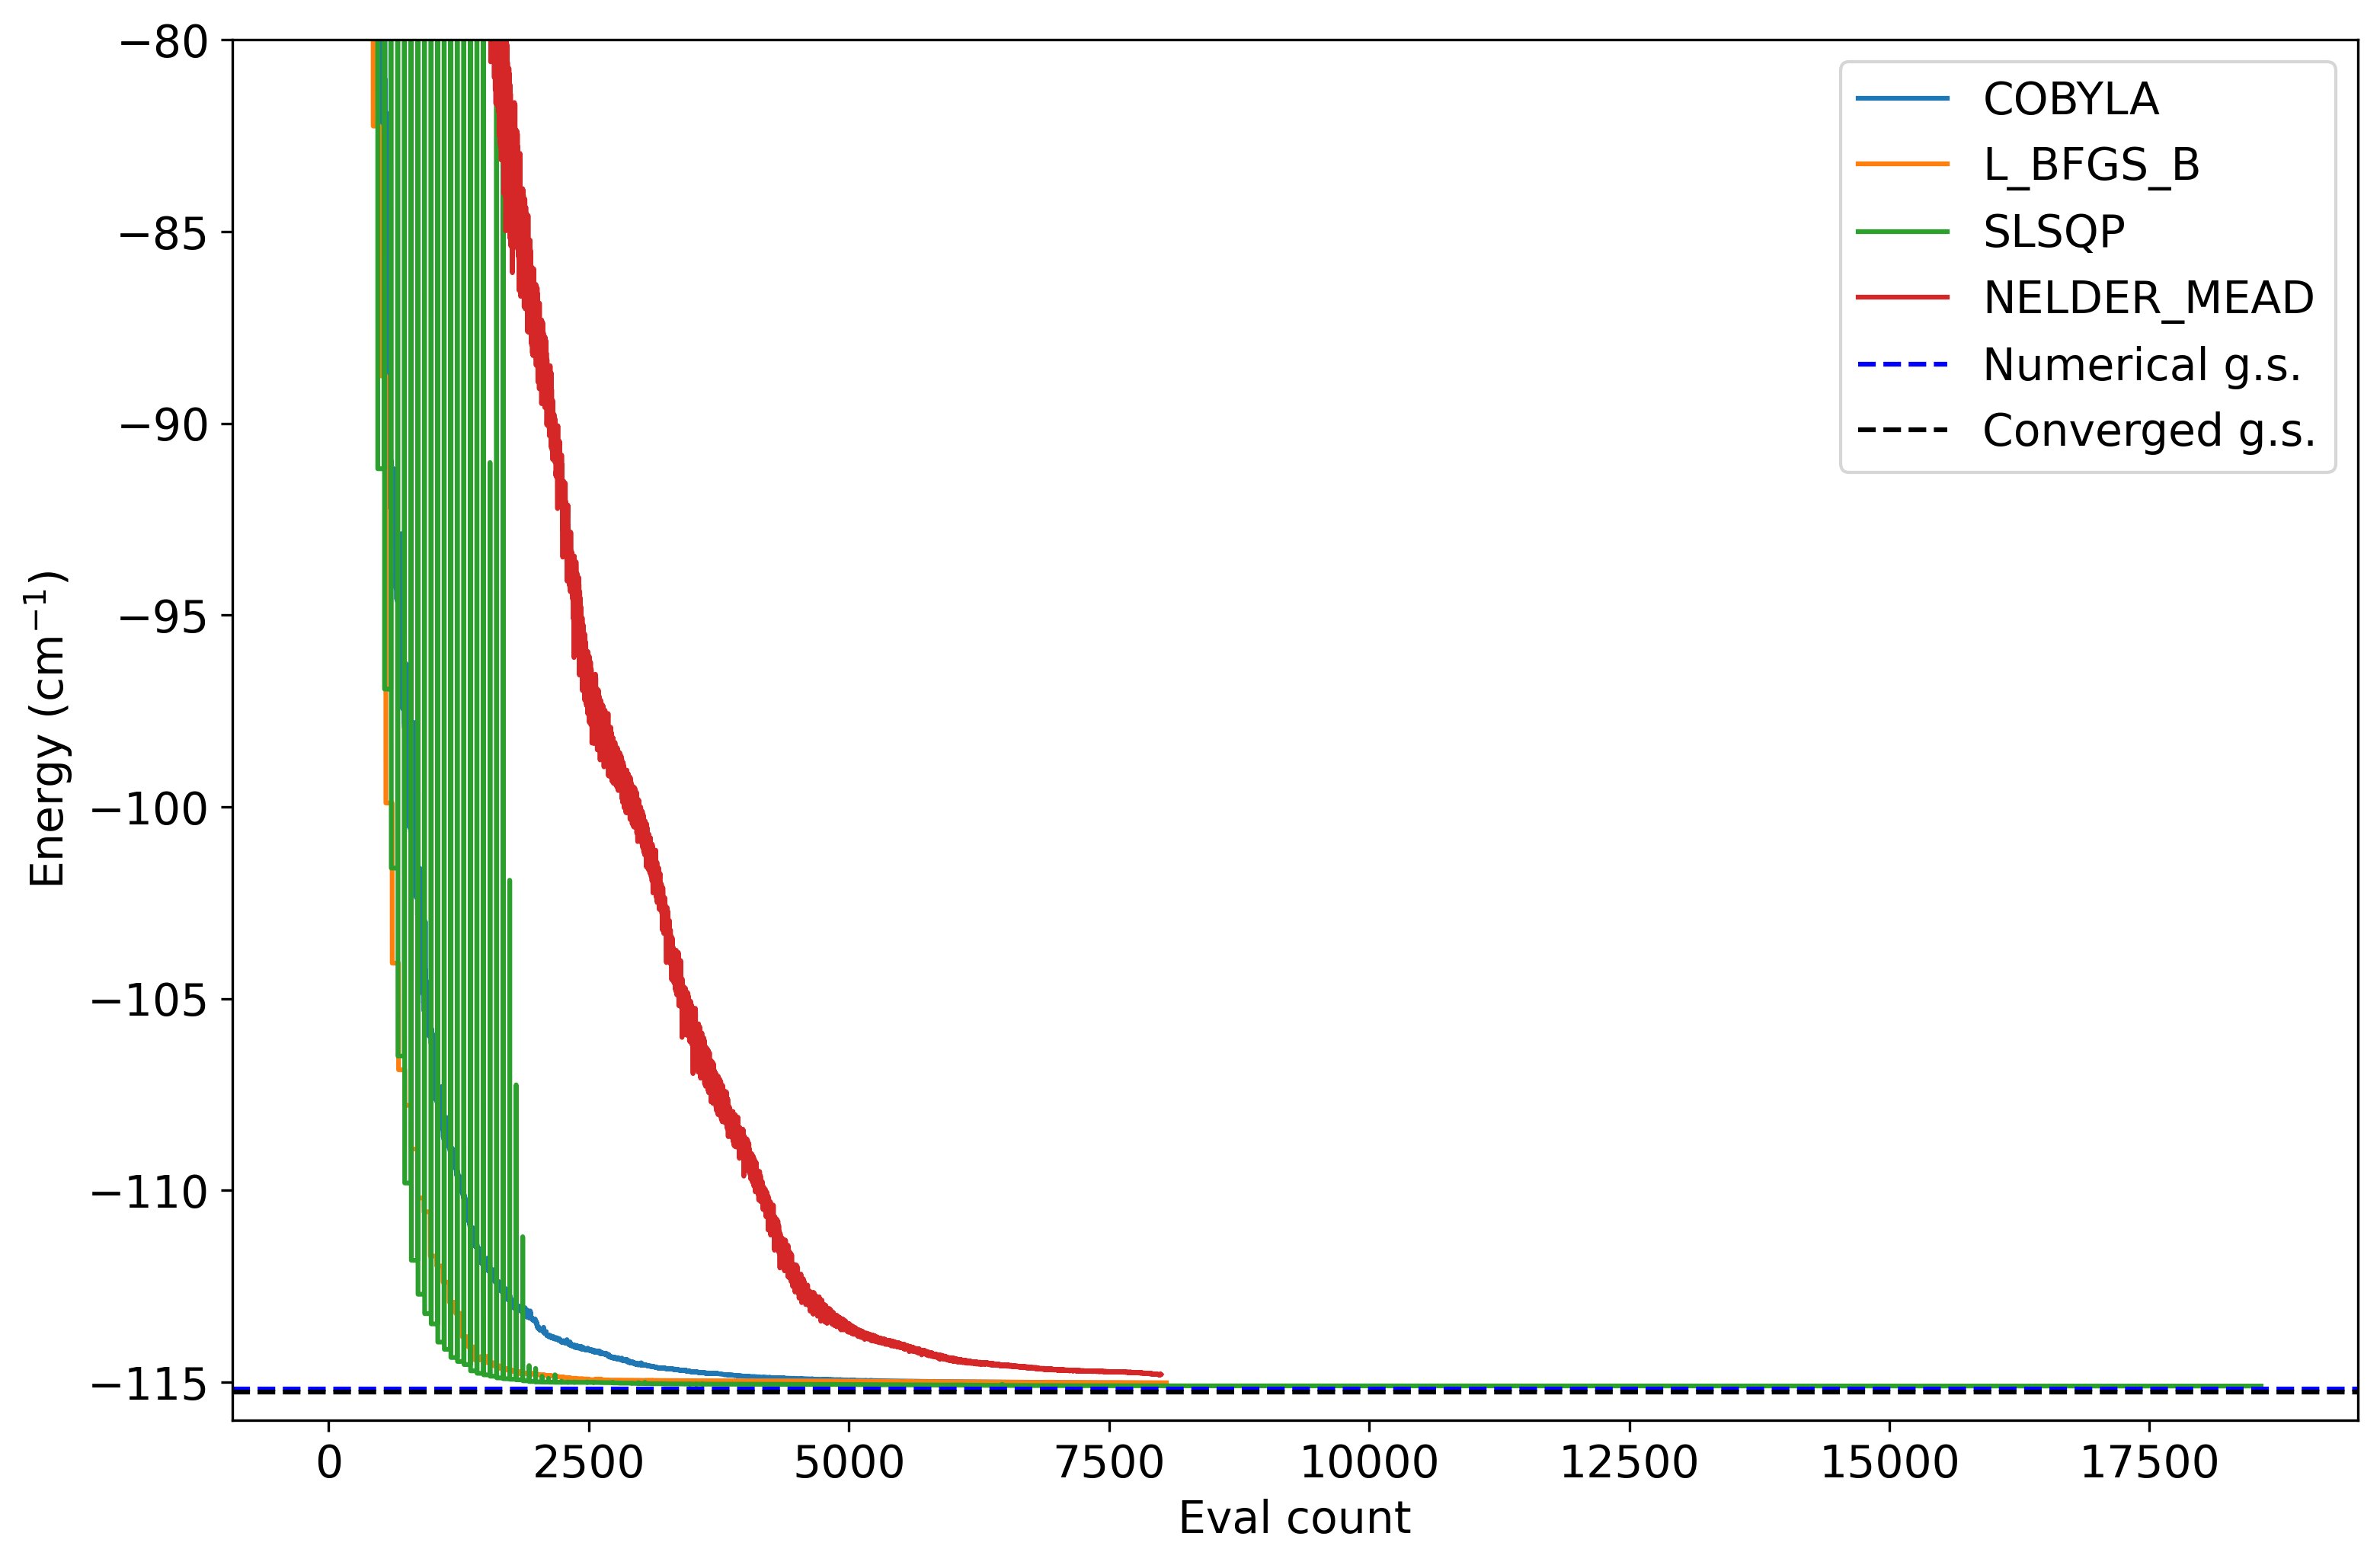

In [41]:
import pylab

ref = -115.26788457220933
# print(converge_cnts2, converge_vals2)
pylab.rcParams['figure.figsize'] = (12, 8)
for i, optimizer in enumerate(optimizers):
    print(type(optimizer).__name__, converge_vals2[i][-1], abs(ref - converge_vals2[i][-1]))
    pylab.plot(converge_cnts2[i], converge_vals2[i], label=type(optimizer).__name__)
# pylab.axhline(eigvals[0])

print(abs(ref - eigvals[0]))
pylab.axhline(eigvals[0], ls='--', c='blue', label='Numerical g.s.')
pylab.axhline(ref, ls='--', c='black', label='Converged g.s.')
pylab.xlabel('Eval count')
pylab.ylabel('Energy (cm$^{-1}$)')
# pylab.title('Energy convergence for various optimizers')
# pylab.xlim(800, 1000)
pylab.ylim(-116, -80)
pylab.legend(loc='upper right');

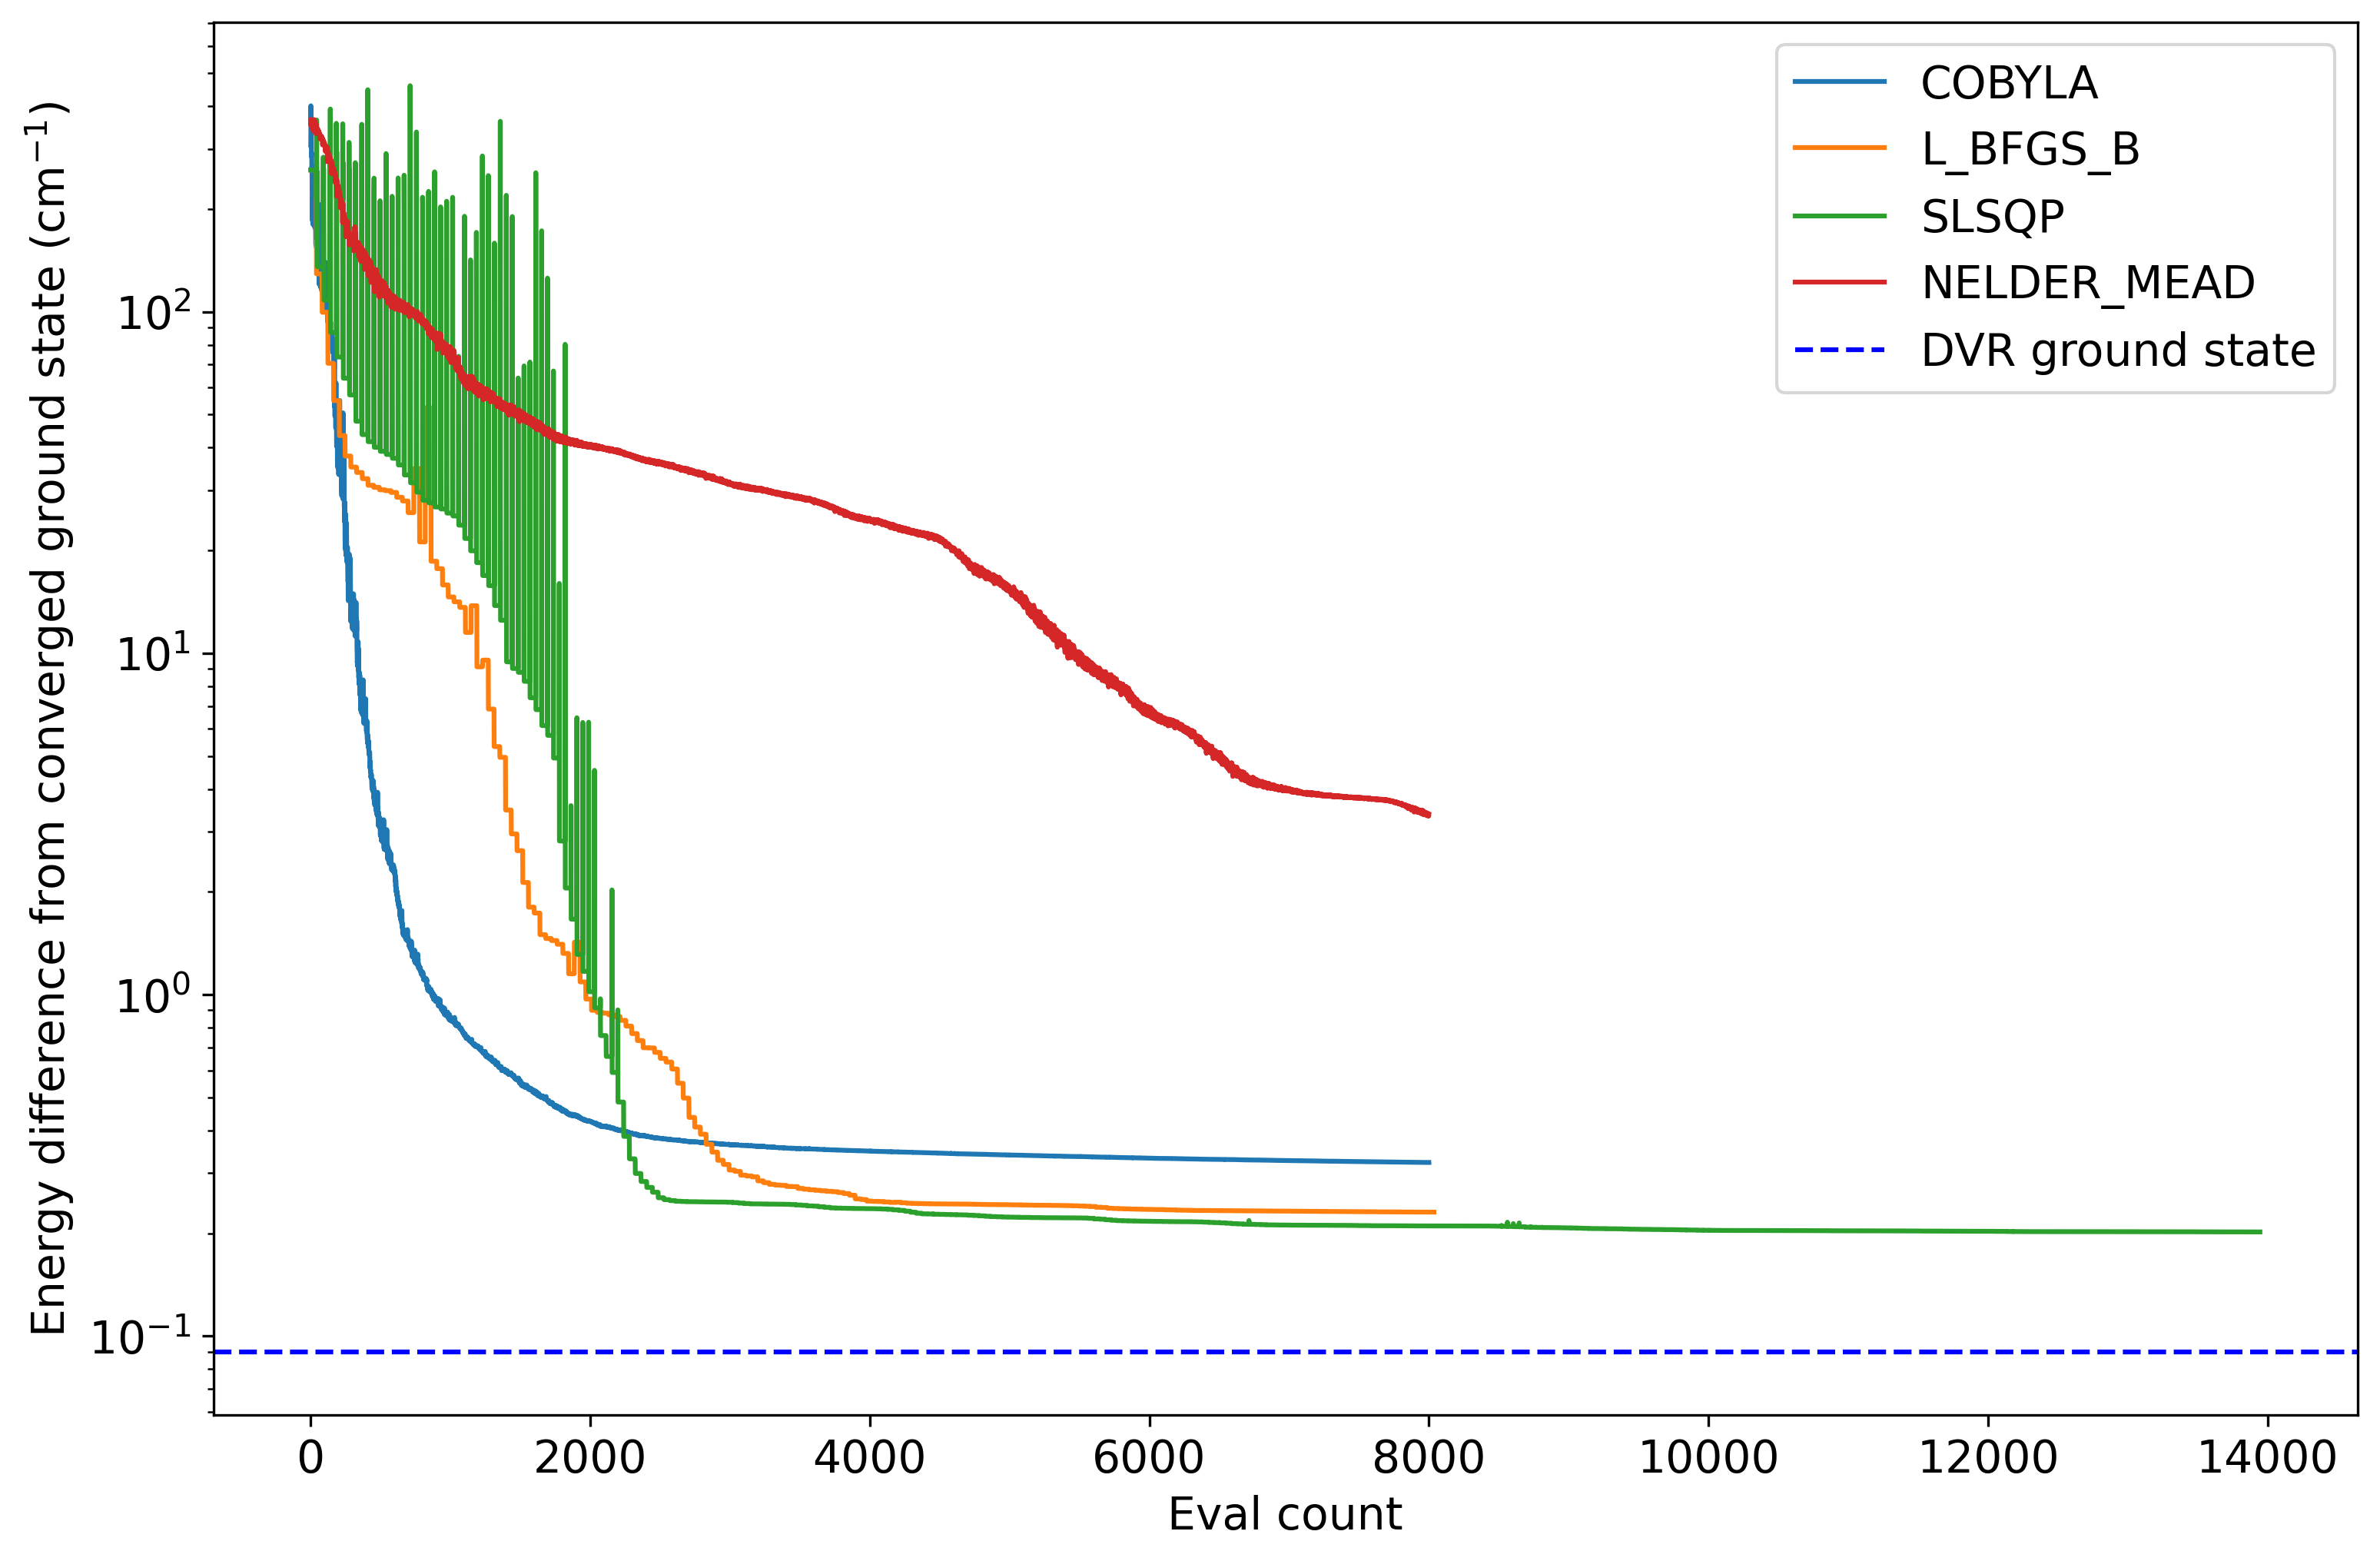

In [36]:
# pylab.rcParams['figure.figsize'] = (12, 8)
for i, optimizer in enumerate(optimizers):
    # pylab.plot(converge_cnts1[i][:], abs(ref - converge_vals1[i][:]), label=type(optimizer).__name__)
    pylab.plot(converge_cnts2[i][:], abs(ref - converge_vals2[i][:]), label=type(optimizer).__name__)
pylab.axhline(abs(ref - eigvals[0]), ls='--', c='blue', label='DVR ground state')
pylab.xlabel('Eval count')
pylab.ylabel('Energy difference from converged ground state (cm$^{-1}$)')
# pylab.title('Energy convergence for various optimizers')
pylab.yscale('log')
# plt.ylim(0,1)
pylab.legend(loc='upper right');
# print(abs(ref - converge_vals1[:, -1]))